# [Bacterial Colony Growth](@id Bacteries)

In [1]:
using CellBasedModels
using CUDA
using Distributions
using CairoMakie
using GeometryBasics
Makie.inline!(true);

In [2]:
function plotRod2D!(ax, x, y, r, l, angle, color)

    pos = [x,y]
    dir = [cos(angle), sin(angle)]
    extreme1 = GeometryBasics.Point((pos+l/2*dir)...,0.)
    extreme2 = GeometryBasics.Point((pos-l/2*dir)...,0.)

    ci = GeometryBasics.Cylinder(extreme1,extreme2,Float64(r))
    b1 = GeometryBasics.Sphere(extreme1,Float64(r))
    b2 = GeometryBasics.Sphere(extreme2,Float64(r))    

    mesh!(ax,b1,color=color)
    mesh!(ax,b2,color=color)
    mesh!(ax,ci,color=color)

end

function plotRods2D!(ax, x, y, r, l, angle, color)

    for i in 1:length(x)
        plotRod2D!(ax, x[i], y[i], r[i], l[i], angle[i], color[i])
    end

end

plotRods2D! (generic function with 1 method)

In [3]:
rod2D = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64
        ),    #Local Interaction Parameters

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m 
        dt(vy) =  -β*vy+fy/m 
        dt(theta) =  ω 
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end
);


In [4]:
com = Community(rod2D,
            N=2,
            dt=0.1,
            simBox = [-20 20;-20 20.],
            neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
            platform=GPU(),
            agentAlg = CBMIntegrators.Heun()
            );

m = 100
g = 10000
d = 1
com.kn = 2E6 / (m*g/d)
com.γn = 2.2E2 / sqrt(g/d)
com.γt = 2.2E2 / sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .5
com.βω = .1

com.m = 1
com.d = 1
com.l = 2.99;

com.x = [0.,3.5]
com.y = [0.,0.0]
com.theta = [0,0.0];

In [5]:
evolve!(com,steps=200,saveEach=10,preallocateAgents=0)

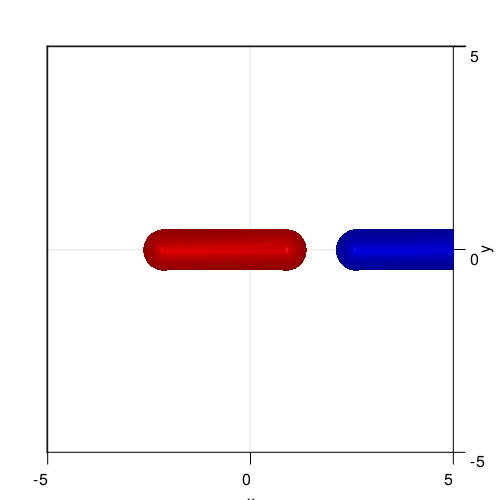

In [6]:
fig = Figure(resolution=(500,500))

ax = Axis3(fig[1,1],
            azimuth=3*π/2,
            elevation=π/2,
            zlabelvisible=false,
            zticklabelsvisible=false,
            zgridvisible=false,
            zspinesvisible=false
        )

plotRods2D!(ax,com[:x],com[:y],com[:d]./2,com[:l],com[:theta],[:red,:blue])
xlims!(-5,5)
ylims!(-5,5)

display(fig)

In [7]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64
            ),

    agentODE = quote
        dt(l) = growth/(1+α*pressure) #linear growth
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1)
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = ω+ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget)
                    )
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = ω-ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget)
                    )
            @removeAgent()
        end
    end,
);

In [55]:
com = Community(rods2dGrowth,
            N=1,
            dt=0.1,
            simBox = [-100 100;-100 100.],
            neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
            platform=GPU(),
            agentAlg=CBMIntegrators.Heun()
            );

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.growth = 1E-6 * (sqrt(g*d)) *100000
com.lMax = 3.     
com.σlTarget = .2 
com.α = 50

com.m = 1.        
com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  

com.x = 0
com.y = 0
com.theta = 0;

In [56]:
evolve!(com,steps=150000,saveEach=1000,preallocateAgents=10000,saveCurrentState=true)

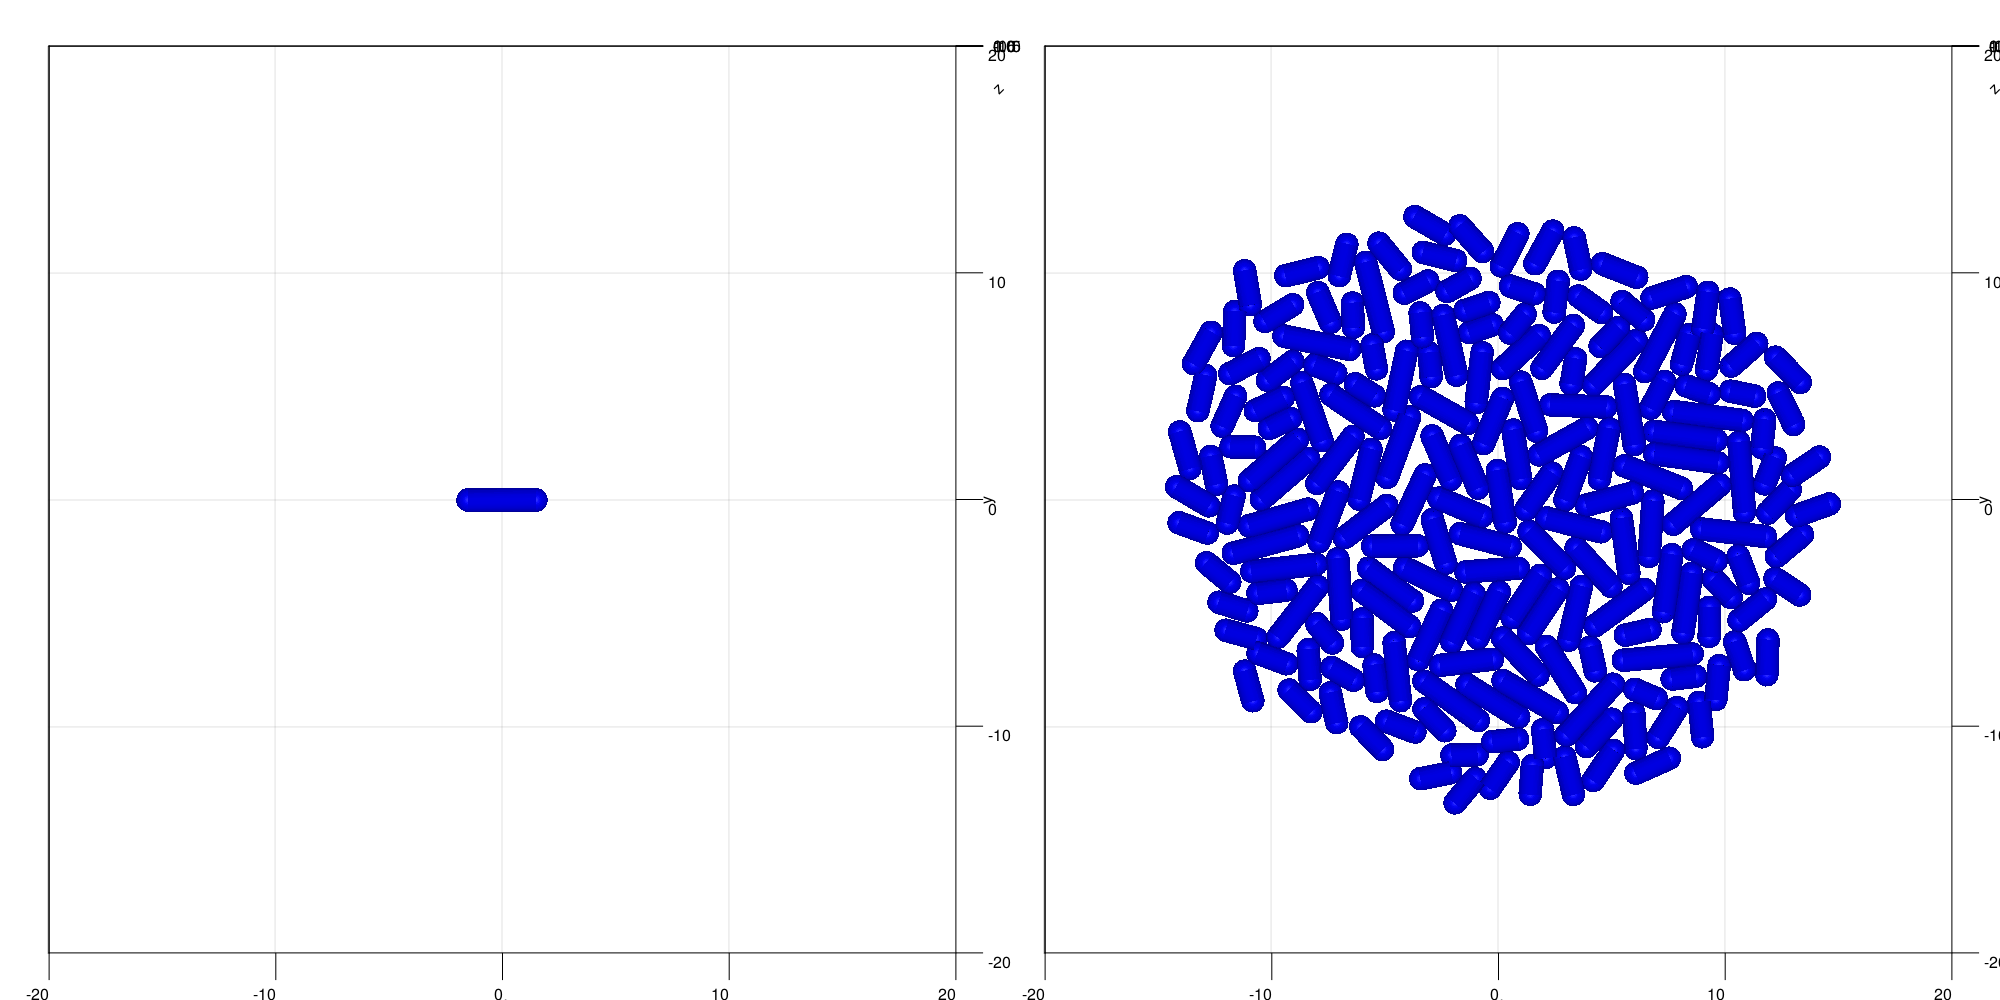

In [57]:
d = getParameter(com,[:x,:y,:d,:l,:theta,:pressure])

fig = Figure(resolution=(2000,1000))

for (i,t) in enumerate([1,length(com)])

    ax = Axis3(fig[1,i],elevation=.5*π,azimuth=1.5*π,viewmode=:fitzoom,aspect = :data)

    plotRods2D!(ax,d[:x][t],d[:y][t],d[:d][t],d[:l][t],d[:theta][t],[:blue for i in 1:length(d[:x][t])])

    xlims!(ax,-20,20)
    ylims!(ax,-20,20)
    
end

fig

In [58]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    meshscatter!(ax,
                x,
                y,
                marker=GeometryBasics.Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotations=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, markerSphere, markerCylinder, angle; kargs...)

    meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markersizeSphere,
                kargs...
            )

    meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markersizeSphere,
                kargs...
            )
            
    meshscatter!(ax,
                x,
                y,
                marker=GeometryBasics.Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markersizeCylinder,
                rotations=angle,
                kargs...
            )

    return

end

plotRods2D! (generic function with 2 methods)

In [64]:
fig = Figure(resolution=(1000,1000))
ax = Axis3(fig[1,1],
            azimuth=3*π/2,
            elevation=π/2,
            zlabelvisible=false,
            zticklabelsvisible=false,
            zgridvisible=false, 
            zspinesvisible=false
        )

x = Observable(com.x)
y = Observable(com.y)
ms = Observable([Point3f(i/2,i/2,0) for i in com.l])
mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(com.l,com.d)])
theta = Observable(com.theta)
pressure = Observable(com.pressure)

plotRods2D!(ax,x,y,ms,mc,theta,pressure)

xlims!(-20,20)
ylims!(-20,20)

display(fig)

In [13]:
# d = getParameter(com,[:N,:x,:y,:d,:l,:theta])
# colorMap = Dict(1=>:blue,2=>:orange,3=>:green)
# for (i,time) in enumerate(1:length(com))
#     fig = Figure(resolution=(2000,2000))
#     ax = Axis3(fig[1,1],
#             azimuth=3*π/2,
#             elevation=π/2,
#             zlabelvisible=false,
#             zticklabelsvisible=false,
#             zgridvisible=false,
#             zspinesvisible=false
#         )

#     plotRods2D!(ax,d[:x][time],d[:y][time],d[:d][time]./2,d[:l][time],d[:theta][time],d[:theta][:pressure])

#     xlims!(ax,(com.simBox[1,:].+[-1,1])...)
#     ylims!(ax,(com.simBox[2,:].+[-1,1])...)

#     ind = "000$i"
#     save("video/Bacteries$(ind[end-2:end]).svg",fig)
# end